# Step 1: Import library 

In [24]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from scipy.sparse import coo_matrix
from spacy.cli.train import train

# Step 2: Loading Data

In [25]:
# read dataset , tsv file meaning that value separated by \t
train_data = pd.read_csv('rawdata.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [26]:
train_data.shape

(5000, 32)

## Drop unnessary column

In [27]:
#Filtering of data as per our need choosing necessary columns
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Price', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Price,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",8.95,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",29.86,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,7.99,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


# Preprocessing 

In [28]:
train_data['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [29]:
train_data.shape

(5000, 11)

In [30]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Uniq Id                5000 non-null   object 
 1   Product Id             5000 non-null   object 
 2   Product Rating         2194 non-null   float64
 3   Product Reviews Count  3346 non-null   float64
 4   Product Category       4990 non-null   object 
 5   Product Brand          4987 non-null   object 
 6   Product Name           5000 non-null   object 
 7   Product Price          4958 non-null   float64
 8   Product Image Url      5000 non-null   object 
 9   Product Description    3873 non-null   object 
 10  Product Tags           5000 non-null   object 
dtypes: float64(3), object(8)
memory usage: 429.8+ KB


In [31]:
# Handling with missing value
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Price              42
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [32]:
train_data = train_data.dropna(subset=['Product Price'])
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'] = train_data['Product Rating'].fillna(0)

# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'] = train_data['Product Reviews Count'].fillna(0)

# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'] = train_data['Product Category'].fillna('')

# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'] = train_data['Product Brand'].fillna('')

# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'] = train_data['Product Description'].fillna('')

In [33]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Price            0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

### check duplicate

In [34]:
train_data.duplicated().sum()

np.int64(0)

### rename column for easy control

In [35]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Price': 'Price',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'    
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4958 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4958 non-null   object 
 1   ProdID       4958 non-null   object 
 2   Rating       4958 non-null   float64
 3   ReviewCount  4958 non-null   float64
 4   Category     4958 non-null   object 
 5   Brand        4958 non-null   object 
 6   Name         4958 non-null   object 
 7   Price        4958 non-null   float64
 8   ImageURL     4958 non-null   object 
 9   Description  4958 non-null   object 
 10  Tags         4958 non-null   object 
dtypes: float64(3), object(8)
memory usage: 464.8+ KB


In [37]:
#change value to numeric 
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

# Step 2: EDA (Exploratory Data Analysis)

In [38]:
unique_ratings = sorted(train_data['Rating'].unique())

# Print the sorted unique values
print(unique_ratings)

[np.float64(0.0), np.float64(1.0), np.float64(1.3), np.float64(1.5), np.float64(1.8), np.float64(2.0), np.float64(2.1), np.float64(2.2), np.float64(2.3), np.float64(2.4), np.float64(2.5), np.float64(2.6), np.float64(2.7), np.float64(2.8), np.float64(2.9), np.float64(3.0), np.float64(3.1), np.float64(3.2), np.float64(3.3), np.float64(3.4), np.float64(3.5), np.float64(3.6), np.float64(3.7), np.float64(3.8), np.float64(3.9), np.float64(4.0), np.float64(4.1), np.float64(4.2), np.float64(4.3), np.float64(4.4), np.float64(4.5), np.float64(4.6), np.float64(4.7), np.float64(4.8), np.float64(4.9), np.float64(5.0)]


In [39]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")


Number of unique users: 1712
Number of unique items: 1679


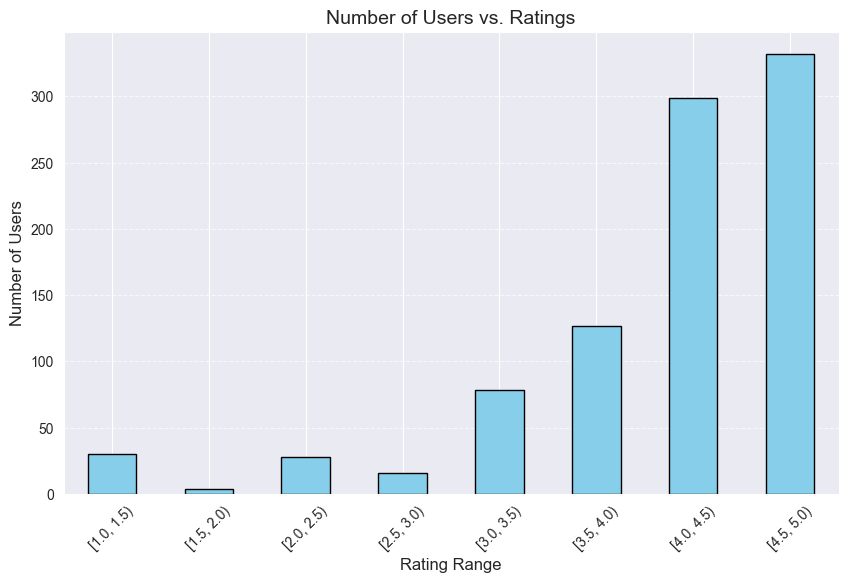

In [40]:
rating_bins = pd.cut(train_data['Rating'], bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], right=False)

# Count the number of unique users (IDs) in each bin
user_rating_counts = train_data.groupby(rating_bins, observed=True)['ID'].nunique()
# Plot the relationship
plt.figure(figsize=(10, 6))
user_rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.xlabel('Rating Range', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Number of Users vs. Ratings', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [43]:
# Define the rating bins
rating_bins = pd.cut(train_data['Rating'], bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], right=False)

# Count the number of unique users (IDs) in each bin
user_rating_counts = train_data.groupby(rating_bins, observed=True)['ID'].nunique()

# Print the result
print(user_rating_counts)

Rating
[1.0, 1.5)     30
[1.5, 2.0)      4
[2.0, 2.5)     28
[2.5, 3.0)     16
[3.0, 3.5)     78
[3.5, 4.0)    127
[4.0, 4.5)    299
[4.5, 5.0)    332
Name: ID, dtype: int64


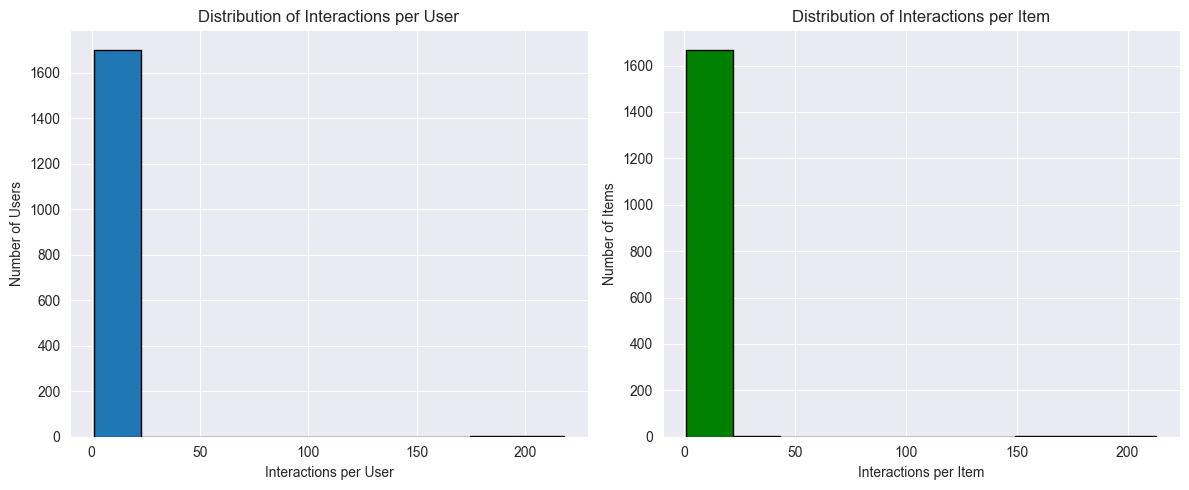

In [41]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

In [42]:
import pandas as pd

# Distribution of user interactions
user_interactions = train_data['ID'].value_counts()
user_bins = [0, 5, 10, 20, 30, float('inf')]
user_labels = ['[0;5)', '[5;10)', '[10;20)', '[20;30)', '30+']
user_distribution = pd.cut(user_interactions, bins=user_bins, labels=user_labels, right=False).value_counts()

# Distribution of product ratings
item_interactions = train_data['ProdID'].value_counts()
item_bins = [0, 5, 10, 20, 30, float('inf')]
item_labels = ['[0;5)', '[5;10)', '[10;20)', '[20;30)', '30+']
item_distribution = pd.cut(item_interactions, bins=item_bins, labels=item_labels, right=False).value_counts()

# Print the results
print("Distribution of users by number of interactions:")
print(user_distribution.sort_index())

print("\nDistribution of products by number of ratings:")
print(item_distribution.sort_index())


Distribution of users by number of interactions:
count
[0;5)      1611
[5;10)       18
[10;20)      71
[20;30)       2
30+          10
Name: count, dtype: int64

Distribution of products by number of ratings:
count
[0;5)      1567
[5;10)       29
[10;20)      71
[20;30)       1
30+          11
Name: count, dtype: int64


In [21]:
train_data

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,Price,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",8.95,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",29.86,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,7.99,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",5.16,https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",19.97,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",14.99,https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou..."
4996,0.000000e+00,1.0,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,4.44,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,3.400000e+01,96.0,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",15.78,https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,9.000000e+00,7.0,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,32.99,https://i5.walmartimages.com/asr/3dc99239-66d2...,,Creed Love In Black Hair And Body Wash 6.8oz/2...


# Step 3: Data Cleaning and Tags Creations

In [22]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.7 MB/s eta 0:00:08
     ---------------------------------------- 0.1/12.8 MB 1.7 MB/s eta 0:00:08
     --------------------------------------- 0.1/12.8 MB 762.6 kB/s eta 0:00:17
     --------------------------------------- 0.1/12.8 MB 581.0 kB/s eta 0:00:22
     --------------------------------------- 0.1/12.8 MB 607.9 kB/s eta 0:00:21
      --------------------


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

# List of columns to extract tags from, including 'Name'
columns_to_extract_tags_from = ['Name', 'Category', 'Brand', 'Description']

# Create new columns for cleaned tags
for column in columns_to_extract_tags_from:
    train_data[f'{column}_Tags'] = train_data[column].apply(clean_and_extract_tags)

# Concatenate the cleaned tags from all relevant columns into a 'Tags' column
train_data['Tags'] = train_data[[f'{col}_Tags' for col in columns_to_extract_tags_from]].apply(lambda row: ', '.join(row), axis=1)

# Example of how the DataFrame looks after adding the new columns
train_data.head()


,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,Price,ImageURL,Description,Tags,Name_Tags,Category_Tags,Brand_Tags,Description_Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",8.95,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"opi, infinite, shine, nail, lacquer, nail, pol...","opi, infinite, shine, nail, lacquer, nail, pol...","premium, beauty, premium, makeup, premium, nai...",opi,
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",29.86,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"nice, n, easy, permanent, color, 111, natural,...","nice, n, easy, permanent, color, 111, natural,...","beauty, hair, care, hair, color, auburn, hair,...",easy,"pack, 3, pack, 3, upc, 381519000201, beautiful..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,7.99,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,"clairol, nice, n, easy, permanent, color, natu...","clairol, nice, n, easy, permanent, color, natu...","beauty, hair, care, hair, color, permanent, ha...",clairol,"clairol, nice, n, easy, permanent, color, give..."
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",5.16,https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"kokie, professional, matte, lipstick, hot, ber...","kokie, professional, matte, lipstick, hot, ber...","beauty, makeup, lip","kokie, cosmetics","calling, matte, lip, lovers, indulge, rich, cr..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",19.97,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","gillette, trac, ii, plus, razor, blade, refill...","gillette, trac, ii, plus, razor, blade, refill...","seasonal, stock, essentials, personal, care, s...",gillette,"1971, gillette, introduced, trac, ii, razor, s..."


In [24]:
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'Price', 'ImageURL', 'Description', 'Tags', 'Name_Tags',
       'Category_Tags', 'Brand_Tags', 'Description_Tags'],
      dtype='object')

In [25]:
train_data=train_data[['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'Price', 'ImageURL', 'Description', 'Tags']]


train_data.to_csv('data/clean_data.csv', index=True)



In [26]:
train_data


,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,Price,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",8.95,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"opi, infinite, shine, nail, lacquer, nail, pol..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",29.86,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"nice, n, easy, permanent, color, 111, natural,..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,7.99,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,"clairol, nice, n, easy, permanent, color, natu..."
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",5.16,https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"kokie, professional, matte, lipstick, hot, ber..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",19.97,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","gillette, trac, ii, plus, razor, blade, refill..."
...,...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",14.99,https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","garden, mint, room, spray, double, strength, 4..."
4996,0.000000e+00,1.0,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,4.44,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,"garnier, nutrisse, nourishing, hair, color, cr..."
4997,3.400000e+01,96.0,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",15.78,https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"nail, file, electric, drill, 6, 1, professiona..."
4998,9.000000e+00,7.0,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,32.99,https://i5.walmartimages.com/asr/3dc99239-66d2...,,"creed, love, black, hair, body, wash, new, box..."


# Rating Base Recommendations System

In [27]:
train_data = pd.read_csv('data/clean_data.csv')

In [28]:
def rating_based_recommendation(data, top_n=10):
    # Calculate average ratings, sort, and select top n items
    top_rated_items = (
        data.groupby(['Name', 'ReviewCount', 'Brand', 'ImageURL'])['Rating']
        .mean().reset_index()
        .sort_values(by=['Rating', 'ReviewCount'], ascending=[False, False])
        .head(top_n)
    )

    # Convert to integer and merge to get all columns, then select necessary columns
    top_rated_items[['Rating', 'ReviewCount']] = top_rated_items[['Rating', 'ReviewCount']].astype(int)
    return top_rated_items.merge(data, on=['Name', 'Rating', 'ReviewCount', 'Brand', 'ImageURL'], how='left')[
        ['Name', 'ImageURL', 'Brand', 'Rating', 'ReviewCount', 'Description', 'Price']
    ]

# Example usage
# Assuming `train_data` is your DataFrame with columns: Name, ReviewCount, Brand, ImageURL, Rating, Description, Price
top_rated_items = rating_based_recommendation(train_data, 10)

# save the data to a new file ('data/trending_new.csv')
top_rated_items.to_csv('data/trending_new.csv', index=False)


top_rated_items

C:\Users\PC\AppData\Local\Temp\ipykernel_4008\3807675032.py:12: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  return top_rated_items.merge(data, on=['Name', 'Rating', 'ReviewCount', 'Brand', 'ImageURL'], how='left')[


,Name,ImageURL,Brand,Rating,ReviewCount,Description,Price
0,"ACT Braces Care Anticavity Mouthwash (18 Oz, C...",https://i5.walmartimages.com/asr/a7fa6e41-316f...,ACT,5,32,Got braces? Start ACTing to help prevent cavit...,3.98
1,"Versace Man Eau Fraiche Eau De Toilette Spray,...",https://i5.walmartimages.com/asr/edaaeed5-9da0...,Versace,5,24,NaN,30.00
2,Tree Hut Shea Sugar Scrub Passion Fruit & Guav...,https://i5.walmartimages.com/asr/be83d31d-81cf...,Tree Hut,5,22,"Enjoy this gentle exfoliator, the Tree Hut She...",6.48
3,Biolage Hydrasource Conditioning Balm For Dry ...,https://i5.walmartimages.com/asr/4a0904fb-a101...,Matrix,5,21,NaN,18.99
4,"Ardell Double Up False Eyelashes, 203",https://i5.walmartimages.com/asr/7c7534ab-b6ea...,Ardell,5,19,New Ardell Double Up lashes are two pairs of e...,8.28
5,"Hello Kids Fluoride Free and SLS Free Rinse, N...",https://i5.walmartimages.com/asr/6998ff2c-58be...,Hello,5,19,Say hello to naturally friendly kids fluoride ...,13.49
6,"ReNew Life CleanseMore, Veggie Caps, 60 ea",https://i5.walmartimages.com/asr/9f707fe4-9ee3...,Renew Life,5,15,Herbal & Mineral FormulaWorks OvernightBrings ...,15.55
7,"(2 Pack) Pro Styl Vitamin &quotE&quot Oil, 6 Oz",https://i5.walmartimages.com/asr/b31a925f-cb2a...,V.I.P.,5,13,NaN,6.83
8,Aura Cacia Essential Oil Frankincense 0.5 fl o...,https://i5.walmartimages.com/asr/d5261a71-0787...,Aura Cacia,5,13,Frankincense oil is a traditional favorite tha...,7.00
9,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,https://i5.walmartimages.com/asr/b3d5462d-d067...,Clay-Park Labs,5,13,Pack of 3 for the UPC: 081642525267 Pearigo Am...,73.55


# Content Base Recommendation system (User Preferences or Items similarities)

In [29]:
train_data['Tags']

0       opi, infinite, shine, nail, lacquer, nail, pol...
1       nice, n, easy, permanent, color, 111, natural,...
2       clairol, nice, n, easy, permanent, color, natu...
3       kokie, professional, matte, lipstick, hot, ber...
4       gillette, trac, ii, plus, razor, blade, refill...
                              ...                        
4953    garden, mint, room, spray, double, strength, 4...
4954    garnier, nutrisse, nourishing, hair, color, cr...
4955    nail, file, electric, drill, 6, 1, professiona...
4956    creed, love, black, hair, body, wash, new, box...
4957    foundation, beauty, makeup, face, makeup, face...
Name: Tags, Length: 4958, dtype: object

# Function To Recommend Products for Content Base

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

"""
Train Data columns: 
['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'Price', 'ImageURL', 'Description', 'Tags']
"""

def content_based_recommendations(data, item_name, top_n=10 ,useful_score = 0.7):
    # Check if the item name exists in the training data
    if item_name not in data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame(), 0.0

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = data[data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices and similarity scores of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]
    similarity_scores = [x[1] for x in top_similar_items]

    # Add similarity scores to the recommended items
    recommended_items_details = data.iloc[recommended_item_indices][['Name', 'ImageURL', 'Brand', 'Rating', 'ReviewCount', 'Description', 'Price']].copy()
    recommended_items_details['SimilarityScore'] = similarity_scores

    # Calculate the ratio of useful recommendations (similarity score > 0.5)
    useful_count = sum(score > useful_score for score in similarity_scores)
    useful_ratio = useful_count / top_n
    
    return recommended_items_details, useful_ratio



In [31]:
# Example: Get content-based recommendations for a specific item
item_name = 'BMC Bright and Loud Cream Gel Lacquer Polish Set - Neon Wasteland Collection'
content_based_rec,useful_ratio = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec


,Name,ImageURL,Brand,Rating,ReviewCount,Description,Price,SimilarityScore
1868,OPI Nail GelColor Gel Polish NEON Color .5oz/1...,https://i5.walmartimages.com/asr/cf655dbc-8e90...,OPI,0.0,0.0,NaN,17.24,0.222477
3033,"Sally Hansen Miracle Gel, 051 Peach Please (Ne...",https://i5.walmartimages.com/asr/54de0e9b-5f65...,Sally Hansen,0.0,11336.0,"&quotGet an up to 8 day mani*. Miracle Gel, ou...",7.46,0.184668
2751,"Sally Hansen Miracle Gel, 053 Miami Ice (Neon)...",https://i5.walmartimages.com/asr/8ecd2ae5-fb6c...,Sally Hansen,0.0,11336.0,"&quotGet an up to 8 day mani*. Miracle Gel, ou...",7.46,0.183538
3094,"Sensationail Express Gel Nail Polish (White), ...",https://i5.walmartimages.com/asr/a6ebc6b8-0fc9...,SensatioNail,0.0,23.0,Bring the nail salon experience to your home w...,11.67,0.177481
4890,Just Gel SLURPLE PURPLE,https://i5.walmartimages.com/asr/e3867ec3-97b2...,ibd,0.0,0.0,"IBD introduces just gel, the strong 100% pure ...",9.95,0.163421
1450,Just Gel BLUE HAVEN,https://i5.walmartimages.com/asr/aa40f091-849d...,ibd,0.0,0.0,"IBD introduces just gel, the strong 100% pure ...",9.99,0.163300
1959,Just Gel INGNUE,https://i5.walmartimages.com/asr/6fb32bc9-0ffd...,ibd,0.0,0.0,"IBD introduces just gel, the strong 100% pure ...",9.95,0.160268
771,"Sally Hansen Miracle Gel Nail Polish, Leaf Me ...",https://i5.walmartimages.com/asr/13c7e57c-526b...,Sally Hansen,4.2,11272.0,"Sally Hansen Miracle Gel Nail Polish, Leaf Me ...",7.46,0.155635


In [32]:
print(f"Useful recommendations:  ({useful_ratio:.2%})")

Useful recommendations:  (0.00%)


In [33]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

(                                                   Name  \
 3379  Kokie Professional Matte Lipstick, Firecracker...   
 542   Kokie Professional Matte Lipstick, Kiss Me, 0....   
 4015  Kokie Professional Lip Poudre Liquid Matte Liq...   
 2383           L.A. Colors Matte Lipstick, Tender Matte   
 2847  Kokie Professional Lip Poudre Liquid Matte Liq...   
 2997                           Be Matte Lipstick - Pink   
 4503                      Be Matte Lipstick - Soft Pink   
 1306                      Be Matte Lipstick - Baby Pink   
 
                                                ImageURL            Brand  \
 3379  https://i5.walmartimages.com/asr/8312221b-ed22...  Kokie Cosmetics   
 542   https://i5.walmartimages.com/asr/27dd82a2-2b9c...  Kokie Cosmetics   
 4015  https://i5.walmartimages.com/asr/fdd7498c-319f...  Kokie Cosmetics   
 2383  https://i5.walmartimages.com/asr/271264fb-e8c3...      L.A. Colors   
 2847  https://i5.walmartimages.com/asr/31c99d9b-ea11...  Kokie Cosmetics

In [34]:
def calculate_average_useful_ratio(train_data, top_n=10, useful_score=0.7, count_num=50):
    # Initialize a list to store useful ratios
    useful_ratios = []

    # Get unique item names and limit to the first `count_num` items
    unique_items = train_data['Name'].unique()[:count_num]

    # Loop through the selected unique item names in the training data
    for item_name in unique_items:
        # Get recommendations and useful ratio for the current item
        _, useful_ratio = content_based_recommendations(train_data, item_name, top_n, useful_score)

        # Print the useful ratio for the current item
        print(f"Useful Ratio: {useful_ratio:.2%}")

        # Append the useful ratio to the list
        useful_ratios.append(useful_ratio)

    # Convert the list of useful ratios to a pandas Series
    ratios_series = pd.Series(useful_ratios)

    # Print descriptive statistics
    print("\nDescriptive Statistics for Useful Ratios:")
    print(ratios_series.describe())

    # Return the list of ratios and descriptive statistics
    return ratios_series

In [36]:
count_num = len(train_data['Name'].unique()) - 1

In [37]:
average_useful_ratio = calculate_average_useful_ratio(train_data, top_n=5, useful_score = 0.7,count_num = count_num)

Useful Ratio: 100.00%
Useful Ratio: 20.00%
Useful Ratio: 100.00%
Useful Ratio: 40.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 20.00%
Useful Ratio: 0.00%
Useful Ratio: 20.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 100.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 20.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 40.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 20.00%
Useful Ratio: 80.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 20.00%
Useful Ratio: 40.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 20.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 0.00%
Useful Ratio: 40.00%
Useful Ratio: 40.00%
Useful Ratio: 40.00%
Useful Ratio: 20.00%
Useful Ratio: 0.00%

## Run app ( demo) 

In [36]:
!pip install streamlit
!streamlit run app2.py



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
